<a href="https://colab.research.google.com/github/ullasbc02/obesity-risk-analytics/blob/main/notebooks/02_eda_spatial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dataset

In [1]:
!pip install dcor
!pip install pygam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 2.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from shapely.validation import make_valid
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
import dcor
from pygam import LinearGAM, s
import statsmodels.formula.api as smf
from libpysal.weights import Queen
from esda.moran import Moran
import plotly.express as px
from dcor import distance_correlation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATASET = '/content/drive/MyDrive/obesity-risk-analytics/data/processed_final'

In [5]:
df_final = pd.read_csv(
    os.path.join(DATASET, 'df_final.csv'),
    dtype={"GEOID": str, "county_fips": str, "state_fips": str}
)

df_final["GEOID"] = df_final["GEOID"].str.zfill(5)
print("df_final counties:", df_final["GEOID"].nunique())


df_final counties: 3121


In [6]:
target = "obesity_rate"
socio_features = [
    "poverty_rate",
    "median_household_income",
    "unemployment_rate",
]
health_behavior_features = [
    "physical_inactivity_rate",
    "low_access_food_rate",
]
access_features = [
    "shortage_code"   # categorical (0,1,2)
]
ses_features = socio_features + health_behavior_features + access_features

In [7]:
eda_features = socio_features + health_behavior_features + access_features

# Feature Distribution and Correlation

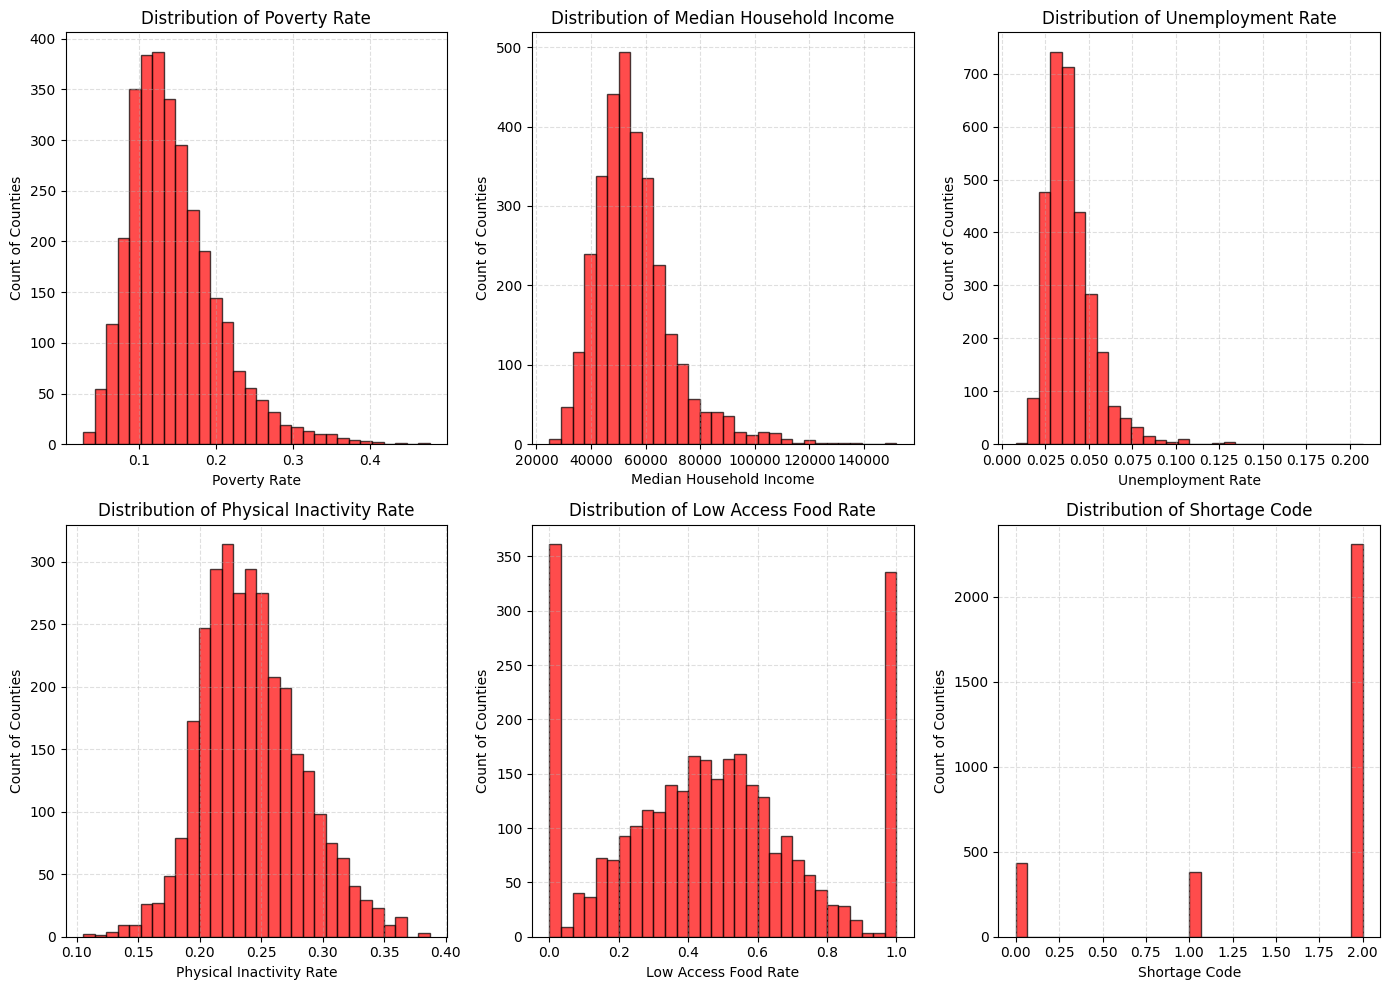

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))
axes = axes.flatten() # Flatten the 2x2 array of axes for easier iteration

for i, feature in enumerate(ses_features):
    ax = axes[i]
    ax.hist(df_final[feature], bins=30, color='red', edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {feature.replace("_", " ").title()}', fontsize=12)
    ax.set_xlabel(feature.replace("_", " ").title(), fontsize=10)
    ax.set_ylabel('Count of Counties', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

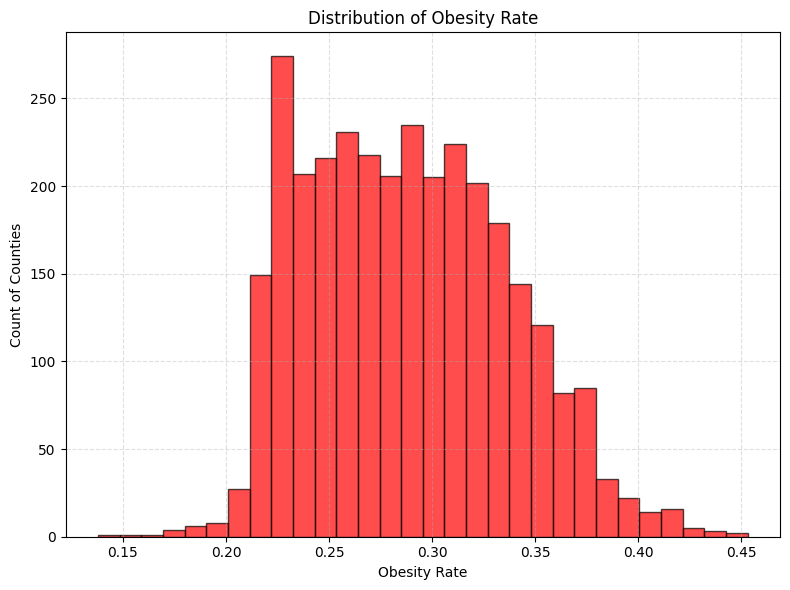

In [9]:
plt.figure(figsize=(8, 6))

plt.hist(
    df_final["obesity_rate"],
    bins=30,
    color="red",
    edgecolor="black",
    alpha=0.7
)

plt.title("Distribution of Obesity Rate", fontsize=12)
plt.xlabel("Obesity Rate", fontsize=10)
plt.ylabel("Count of Counties", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


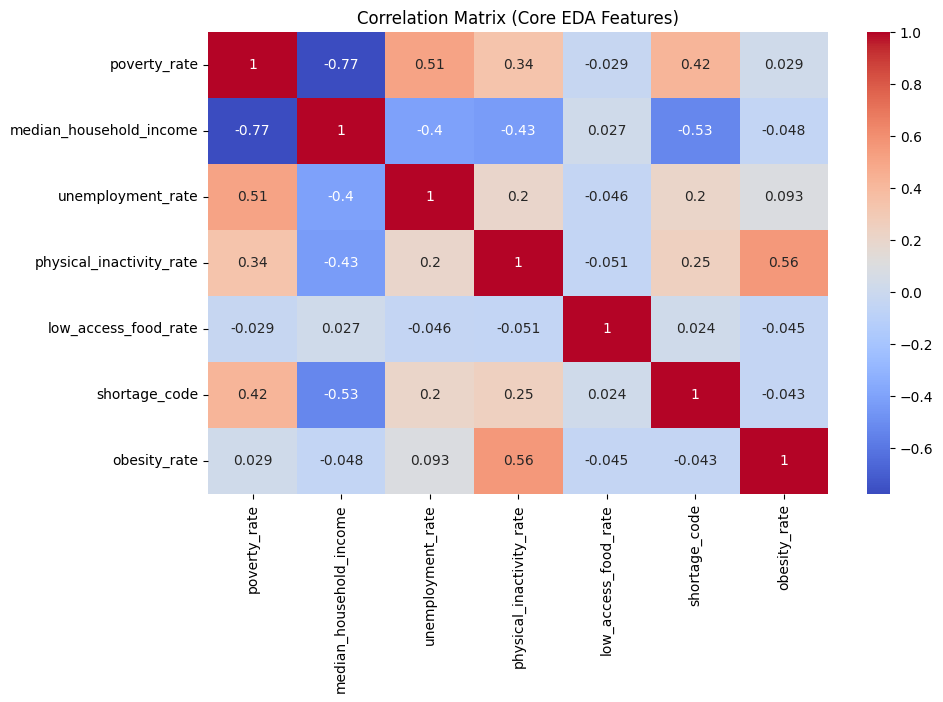

In [10]:
plt.figure(figsize=(10,6))
sns.heatmap(df_final[eda_features + [target]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Core EDA Features)")
plt.show()

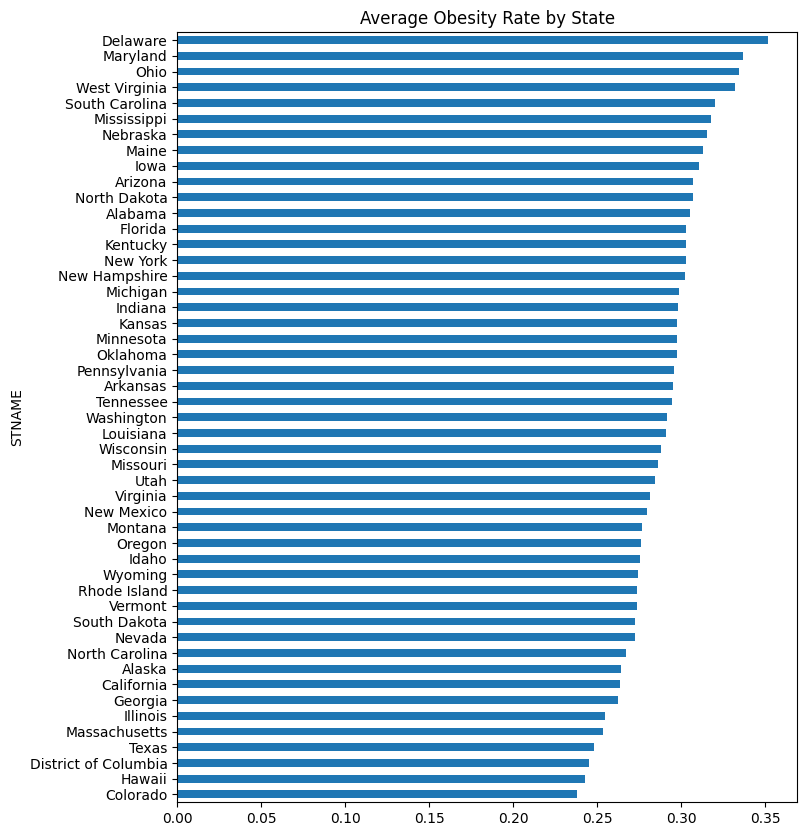

In [11]:
state_avg = df_final.groupby("STNAME")["obesity_rate"].mean().sort_values()
state_avg.plot(kind='barh', figsize=(8,10))
plt.title("Average Obesity Rate by State")
plt.show()


# Finding relationship with features

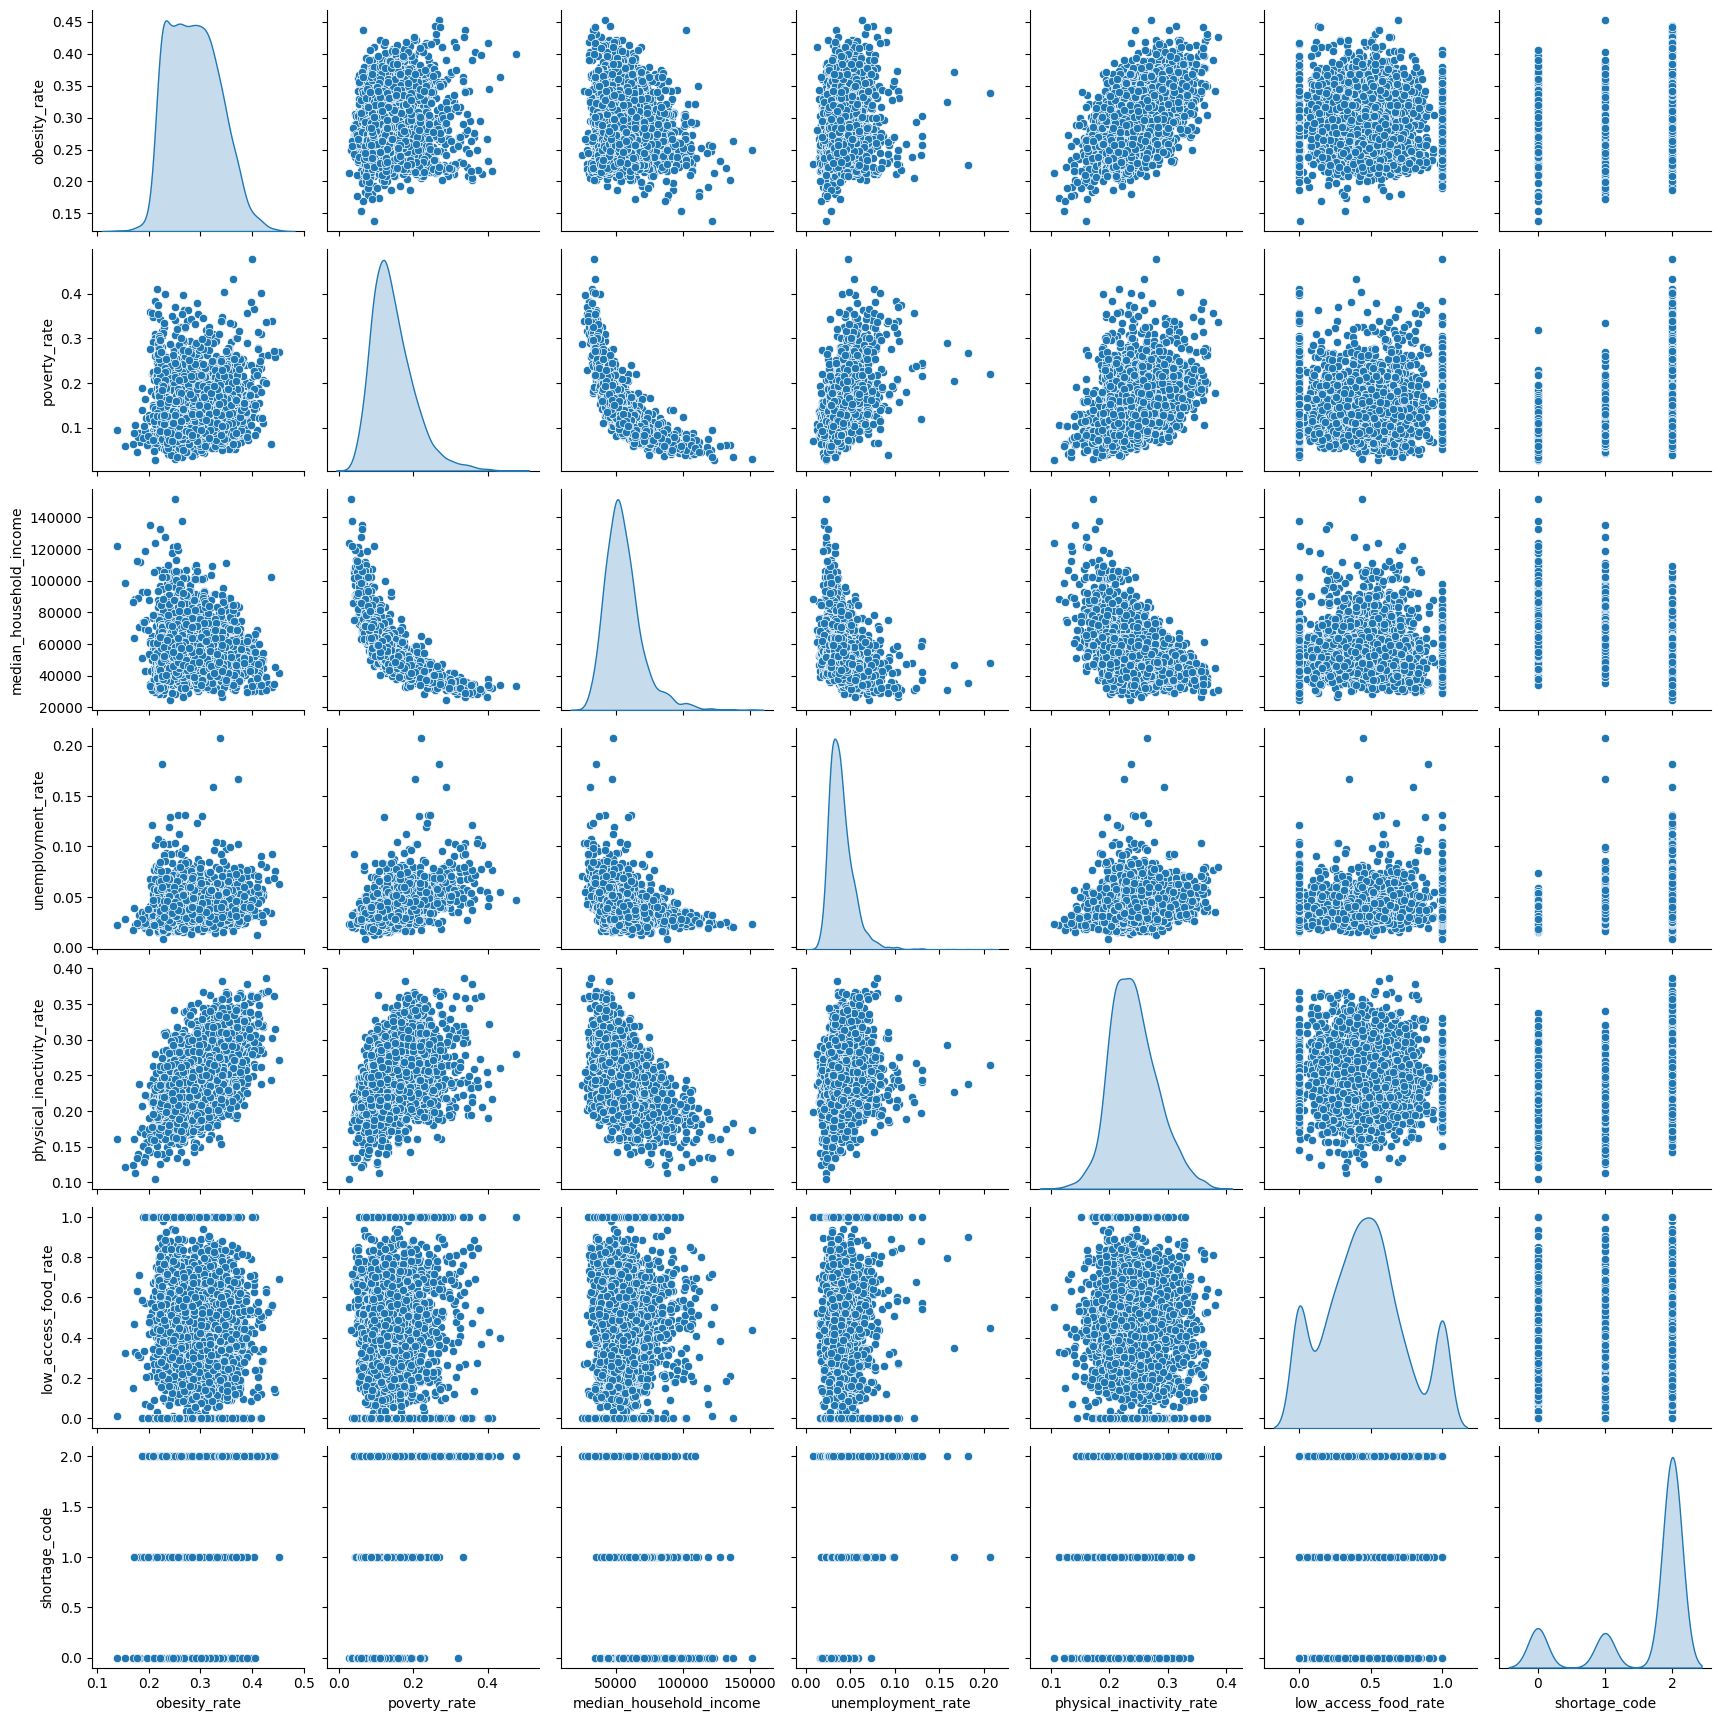

In [12]:
sns.pairplot(df_final[["obesity_rate"] + ses_features], diag_kind="kde")
plt.show()

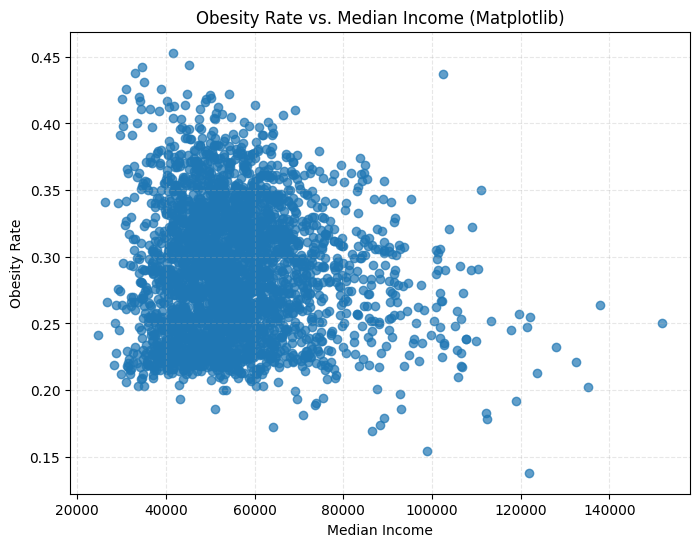

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(x=df_final["median_household_income"], y=df_final["obesity_rate"], alpha=0.7)
plt.title("Obesity Rate vs. Median Income (Matplotlib)")
plt.xlabel("Median Income")
plt.ylabel("Obesity Rate")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

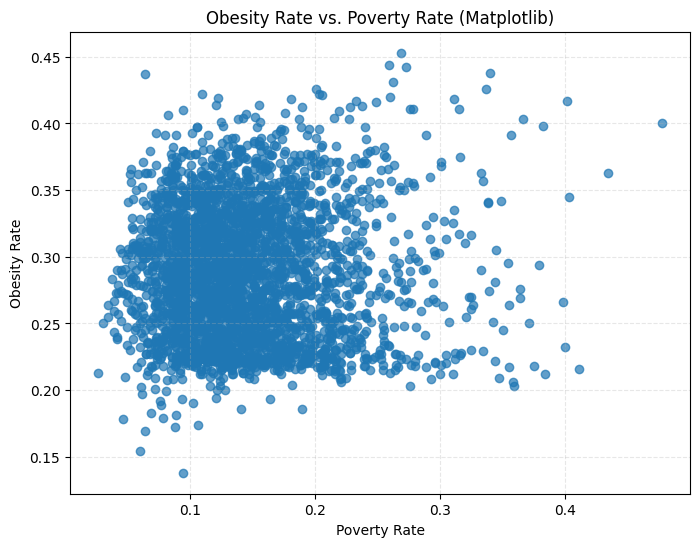

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(x=df_final["poverty_rate"], y=df_final["obesity_rate"], alpha=0.7)
plt.title("Obesity Rate vs. Poverty Rate (Matplotlib)")
plt.xlabel("Poverty Rate")
plt.ylabel("Obesity Rate")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

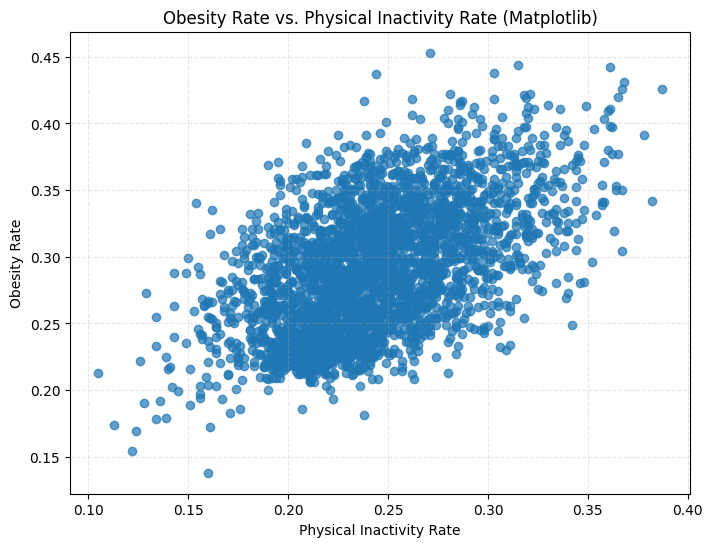

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(x=df_final["physical_inactivity_rate"], y=df_final["obesity_rate"], alpha=0.7)
plt.title("Obesity Rate vs. Physical Inactivity Rate (Matplotlib)")
plt.xlabel("Physical Inactivity Rate")
plt.ylabel("Obesity Rate")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

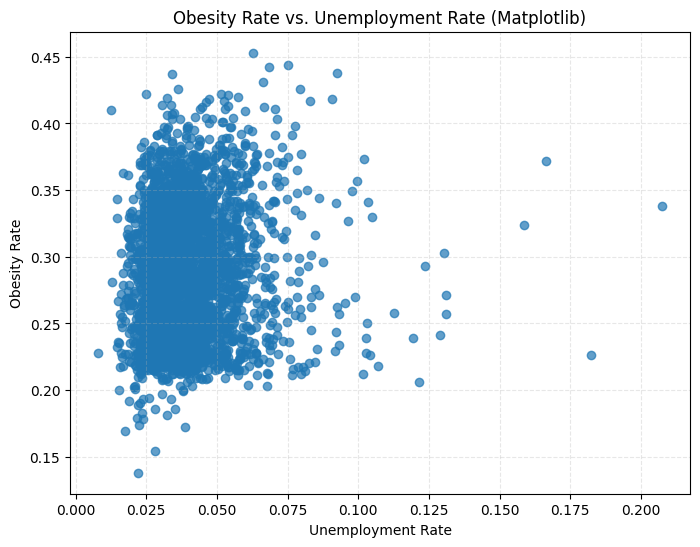

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(x=df_final["unemployment_rate"], y=df_final["obesity_rate"], alpha=0.7)
plt.title("Obesity Rate vs. Unemployment Rate (Matplotlib)")
plt.xlabel("Unemployment Rate")
plt.ylabel("Obesity Rate")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [17]:
def find_correlation(features):
  for col in features:
    print(f"\n--- Correlations for {col.replace('_', ' ').title()} ---")

    # Pearson correlation
    r_pearson, p_pearson = stats.pearsonr(df_final[col], df_final["obesity_rate"])
    print(f"  Pearson r = {r_pearson:.3f}, p = {p_pearson:.3e}")

    # Log-Pearson, Spearman, Kendall Tau (only for features also in core_features)

    r_log_pearson, p_log_pearson = stats.pearsonr(np.log1p(df_final[col]), df_final["obesity_rate"])
    print(f"  Log-Pearson r = {r_log_pearson:.3f}, p = {p_log_pearson:.3e}")

    r_spearman, p_spearman = stats.spearmanr(df_final[col], df_final["obesity_rate"])
    print(f"  Spearman \u03C1 = {r_spearman:.3f}, p = {p_spearman:.3e}")

    r_kendall, p_kendall = stats.kendalltau(df_final[col], df_final["obesity_rate"])
    print(f"  Kendall \u03C4 = {r_kendall:.3f}, p = {p_kendall:.3e}")

find_correlation(ses_features)


--- Correlations for Poverty Rate ---
  Pearson r = 0.029, p = 1.090e-01
  Log-Pearson r = 0.029, p = 1.094e-01
  Spearman ρ = -0.005, p = 7.679e-01
  Kendall τ = -0.003, p = 7.799e-01

--- Correlations for Median Household Income ---
  Pearson r = -0.048, p = 7.510e-03
  Log-Pearson r = -0.026, p = 1.423e-01
  Spearman ρ = 0.026, p = 1.395e-01
  Kendall τ = 0.017, p = 1.614e-01

--- Correlations for Unemployment Rate ---
  Pearson r = 0.093, p = 1.684e-07
  Log-Pearson r = 0.095, p = 1.100e-07
  Spearman ρ = 0.097, p = 5.277e-08
  Kendall τ = 0.066, p = 3.416e-08

--- Correlations for Physical Inactivity Rate ---
  Pearson r = 0.559, p = 2.966e-256
  Log-Pearson r = 0.559, p = 9.844e-256
  Spearman ρ = 0.550, p = 9.264e-247
  Kendall τ = 0.382, p = 1.399e-224

--- Correlations for Low Access Food Rate ---
  Pearson r = -0.045, p = 1.278e-02
  Log-Pearson r = -0.013, p = 4.821e-01
  Spearman ρ = -0.025, p = 1.586e-01
  Kendall τ = -0.016, p = 1.881e-01

--- Correlations for Shortage C

# Analysis

Mutual Information with obesity_rate:
physical_inactivity_rate    0.233860
low_access_food_rate        0.058135
shortage_code               0.054596
median_household_income     0.039719
poverty_rate                0.038051
unemployment_rate           0.009945
dtype: float64


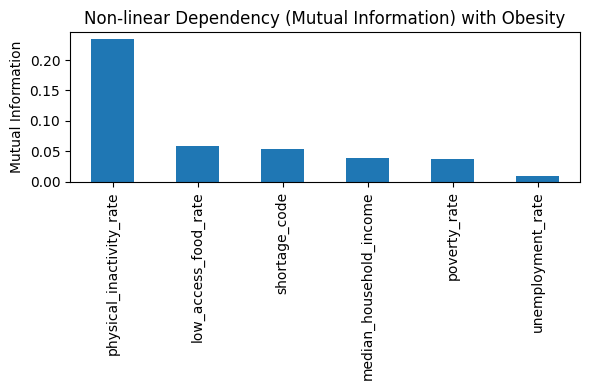

In [18]:
X = df_final[ses_features].copy()
y = df_final[target].values

mi = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi, index=ses_features).sort_values(ascending=False)

print("Mutual Information with obesity_rate:")
print(mi_series)

plt.figure(figsize=(6,4))
mi_series.plot(kind="bar")
plt.ylabel("Mutual Information")
plt.title("Non-linear Dependency (Mutual Information) with Obesity")
plt.tight_layout()
plt.show()

In [19]:
for col in ses_features:
    x = df_final[col].values
    y = df_final[target].values
    d = dcor.distance_correlation(x, y)
    print(f"{col}: distance correlation = {d:.3f}")

poverty_rate: distance correlation = 0.081
median_household_income: distance correlation = 0.089
unemployment_rate: distance correlation = 0.100
physical_inactivity_rate: distance correlation = 0.523
low_access_food_rate: distance correlation = 0.162
shortage_code: distance correlation = 0.084


/usr/local/lib/python3.12/dist-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(int64, 1d, C), array(float64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


In [20]:
X = df_final[ses_features].values
y = df_final[target].values

gam = LinearGAM(
    s(0) + s(1) + s(2) + s(3) + s(4) + s(5) # one smooth term per feature for all 6 features
).fit(X, y)

print("GAM pseudo-R²:", gam.statistics_['pseudo_r2'])

GAM pseudo-R²: OrderedDict({'explained_deviance': np.float64(0.4500110920701801), 'McFadden': np.float64(0.5461456534413146), 'McFadden_adj': np.float64(0.4538232644706459)})


# GAM Partial Dependence Plot

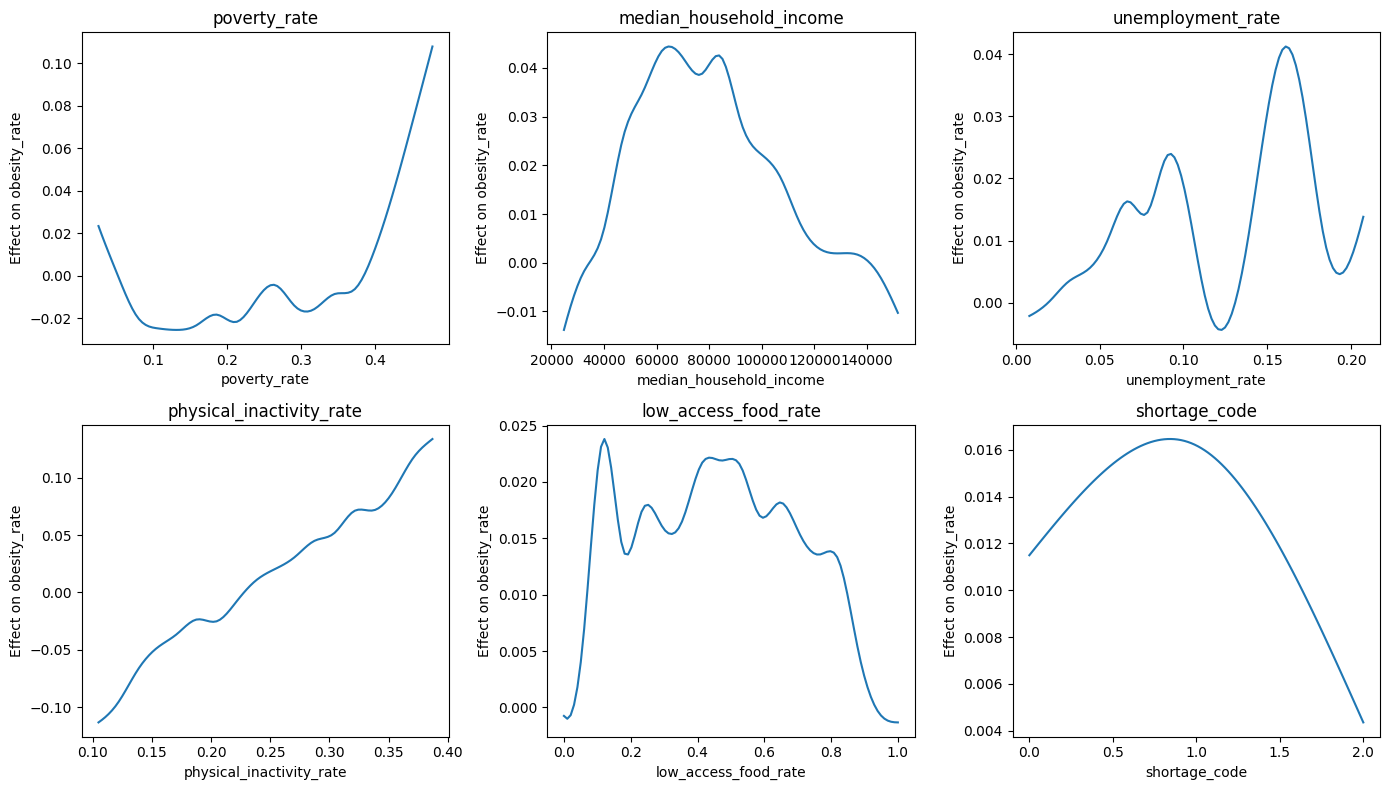

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(14,8))
axs = axs.ravel()

for i, col in enumerate(ses_features):
    XX = gam.generate_X_grid(term=i)
    pdep = gam.partial_dependence(term=i, X=XX)
    axs[i].plot(XX[:, i], pdep)
    axs[i].set_title(col)
    axs[i].set_xlabel(col)
    axs[i].set_ylabel("Effect on obesity_rate")

# All 6 subplots will be used, so no need to hide the last one
# axs[-1].axis("off")

plt.tight_layout()
plt.show()

In [22]:
formula = """
obesity_rate ~ poverty_rate * low_access_food_rate
             + physical_inactivity_rate * median_household_income
             + unemployment_rate
"""

model_int = smf.ols(formula=formula, data=df_final).fit()
print(model_int.summary())

                            OLS Regression Results                            
Dep. Variable:           obesity_rate   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     257.4
Date:                Wed, 10 Dec 2025   Prob (F-statistic):          4.36e-303
Time:                        20:31:49   Log-Likelihood:                 5730.4
No. Observations:                3121   AIC:                        -1.144e+04
Df Residuals:                    3113   BIC:                        -1.140e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

# Demographic Analysis


In [23]:
race_vars = {
    "pct_white":      (df_final["WA_MALE"] + df_final["WA_FEMALE"]) / df_final["TOT_POP"],
    "pct_black":      (df_final["BA_MALE"] + df_final["BA_FEMALE"]) / df_final["TOT_POP"],
    "pct_native":     (df_final["IA_MALE"] + df_final["IA_FEMALE"]) / df_final["TOT_POP"],
    "pct_asian":      (df_final["AA_MALE"] + df_final["AA_FEMALE"]) / df_final["TOT_POP"],
    "pct_pacific":    (df_final["NA_MALE"] + df_final["NA_FEMALE"]) / df_final["TOT_POP"],
    "pct_two_plus":   (df_final["TOM_MALE"] + df_final["TOM_FEMALE"]) / df_final["TOT_POP"],
    "pct_hispanic":   (df_final["H_MALE"] + df_final["H_FEMALE"]) / df_final["TOT_POP"],
    "pct_non_hispanic": (df_final["NH_MALE"] + df_final["NH_FEMALE"]) / df_final["TOT_POP"]
}

for col, val in race_vars.items():
    df_final[col] = val


In [24]:
race_cols = [
    "pct_white", "pct_black", "pct_hispanic", "pct_non_hispanic",
    "pct_asian", "pct_native", "pct_pacific", "pct_two_plus"
]

find_correlation(race_cols)


--- Correlations for Pct White ---
  Pearson r = -0.061, p = 6.705e-04
  Log-Pearson r = -0.062, p = 4.959e-04
  Spearman ρ = -0.017, p = 3.452e-01
  Kendall τ = -0.011, p = 3.535e-01

--- Correlations for Pct Black ---
  Pearson r = 0.054, p = 2.775e-03
  Log-Pearson r = 0.056, p = 1.920e-03
  Spearman ρ = 0.055, p = 2.206e-03
  Kendall τ = 0.037, p = 2.045e-03

--- Correlations for Pct Hispanic ---
  Pearson r = -0.155, p = 2.600e-18
  Log-Pearson r = -0.160, p = 2.895e-19
  Spearman ρ = -0.129, p = 4.013e-13
  Kendall τ = -0.086, p = 5.542e-13

--- Correlations for Pct Non Hispanic ---
  Pearson r = 0.156, p = 2.261e-18
  Log-Pearson r = 0.151, p = 2.818e-17
  Spearman ρ = 0.130, p = 2.833e-13
  Kendall τ = 0.087, p = 3.815e-13

--- Correlations for Pct Asian ---
  Pearson r = -0.055, p = 1.936e-03
  Log-Pearson r = -0.052, p = 3.363e-03
  Spearman ρ = 0.055, p = 1.928e-03
  Kendall τ = 0.036, p = 2.620e-03

--- Correlations for Pct Native ---
  Pearson r = 0.058, p = 1.190e-03
  L

In [25]:
demo_cols = [
    "pct_white", "pct_black", "pct_hispanic",
    "pct_asian", "pct_native"
]

Mutual Information with obesity_rate:
pct_hispanic    0.027764
pct_white       0.018870
pct_native      0.016794
pct_black       0.014640
pct_asian       0.012250
dtype: float64


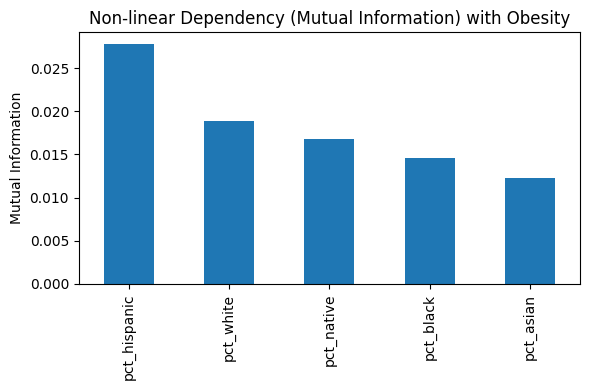

In [26]:
X = df_final[demo_cols].copy()
y = df_final[target].values

mi = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi, index=demo_cols).sort_values(ascending=False)

print("Mutual Information with obesity_rate:")
print(mi_series)

plt.figure(figsize=(6,4))
mi_series.plot(kind="bar")
plt.ylabel("Mutual Information")
plt.title("Non-linear Dependency (Mutual Information) with Obesity")
plt.tight_layout()
plt.show()

In [27]:
X = df_final[race_cols].fillna(0)

mi = mutual_info_regression(X, df_final["obesity_rate"])
for col, val in zip(race_cols, mi):
    print(f"{col}: MI = {val:.4f}")

for col in race_cols:
    print(col, distance_correlation(df_final[col], df_final["obesity_rate"]))

pct_white: MI = 0.0190
pct_black: MI = 0.0145
pct_hispanic: MI = 0.0277
pct_non_hispanic: MI = 0.0263
pct_asian: MI = 0.0124
pct_native: MI = 0.0167
pct_pacific: MI = 0.0033
pct_two_plus: MI = 0.0380
pct_white 0.07025575595307865
pct_black 0.06600760279679654
pct_hispanic 0.18044992630264828
pct_non_hispanic 0.18058532273591216
pct_asian 0.07946719413816752
pct_native 0.0968467396686318
pct_pacific 0.0450416815976127
pct_two_plus 0.03529128130467326


In [28]:
df_final["dominant_group"] = df_final[demo_cols].idxmax(axis=1)

In [29]:
group_stats = (
    df_final.groupby("dominant_group")[["obesity_rate", "poverty_rate", "median_household_income"]]
    .mean()
    .sort_values("obesity_rate", ascending=False)
)

group_stats

,obesity_rate,poverty_rate,median_household_income
dominant_group,,,
pct_native,0.333008,0.281635,42991.580645
pct_hispanic,0.299000,0.262000,41470.000000
pct_black,0.295889,0.252888,40101.289474
pct_white,0.286943,0.139363,56216.828903
pct_asian,0.265007,0.101007,79531.666667


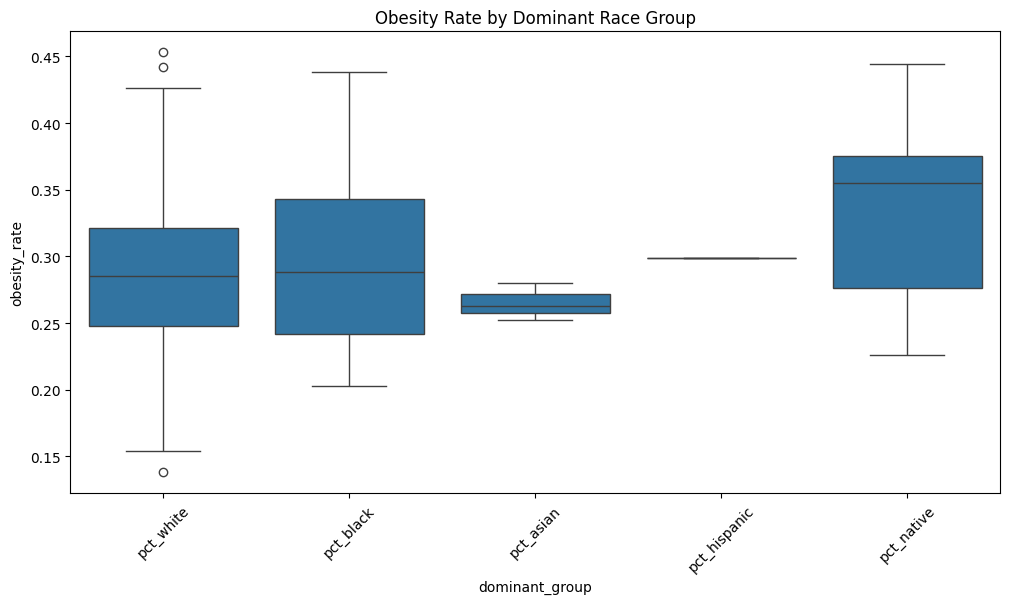

In [30]:
plt.figure(figsize=(12,6))
sns.boxplot(x="dominant_group", y="obesity_rate", data=df_final)
plt.xticks(rotation=45)
plt.title("Obesity Rate by Dominant Race Group")
plt.show()


<Axes: xlabel='pct_black', ylabel='obesity_rate'>

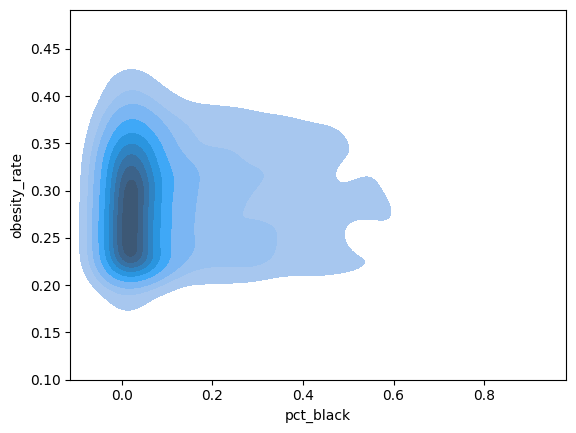

In [31]:
sns.kdeplot(
    x=df_final["pct_black"],
    y=df_final["obesity_rate"],
    fill=True
)

In [32]:
formula = """
obesity_rate ~ physical_inactivity_rate + poverty_rate + median_household_income +
pct_black + pct_hispanic + pct_asian + pct_native + pct_two_plus
"""

model = smf.ols(formula=formula, data=df_final).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           obesity_rate   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     222.0
Date:                Wed, 10 Dec 2025   Prob (F-statistic):          2.34e-298
Time:                        20:31:53   Log-Likelihood:                 5722.3
No. Observations:                3121   AIC:                        -1.143e+04
Df Residuals:                    3112   BIC:                        -1.137e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

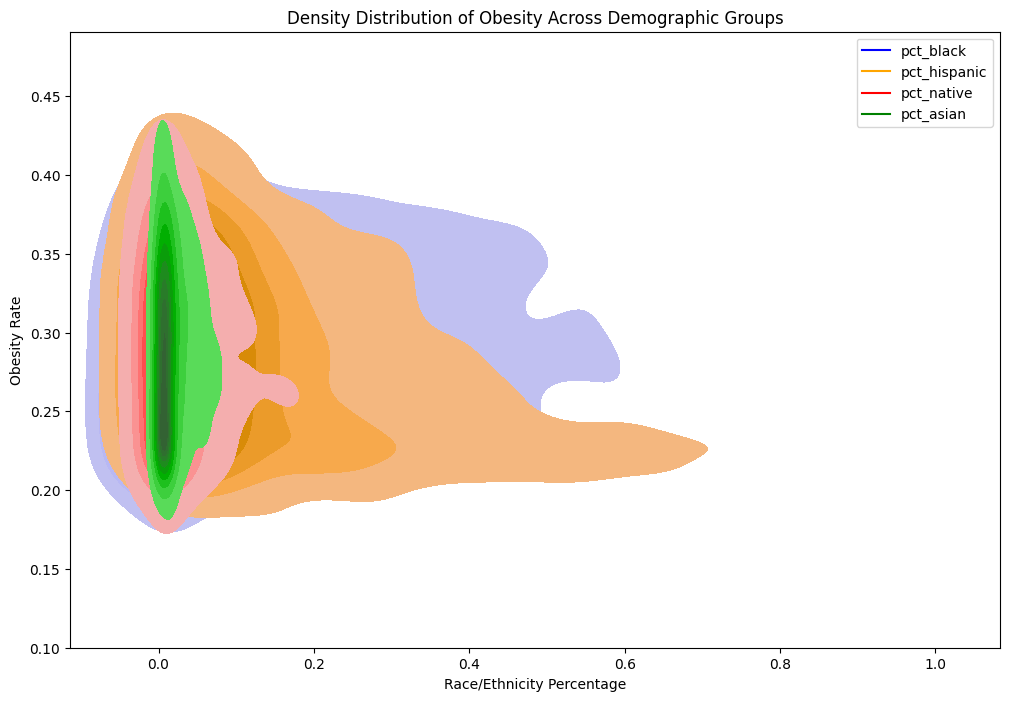

In [33]:
plt.figure(figsize=(12,8))
ax = plt.gca() # Get the current axes object

handles = []
labels = []

for race, color in zip([
    "pct_black",
    "pct_hispanic",
    "pct_native",
    "pct_asian"
], ["blue","orange","red","green"]):
    sns.kdeplot(
        x=df_final[race],
        y=df_final["obesity_rate"],
        fill=True,
        thresh=0.05,
        color=color,
        ax=ax
    )
    # Add a dummy plot for the legend to pick up and collect its handle and label
    line, = ax.plot([], [], color=color, label=race) # The comma unpacks the list returned by plot
    handles.append(line)
    labels.append(race)

plt.title("Density Distribution of Obesity Across Demographic Groups")
plt.xlabel("Race/Ethnicity Percentage")
plt.ylabel("Obesity Rate")
ax.legend(handles=handles, labels=labels) # Pass handles and labels explicitly
plt.show()

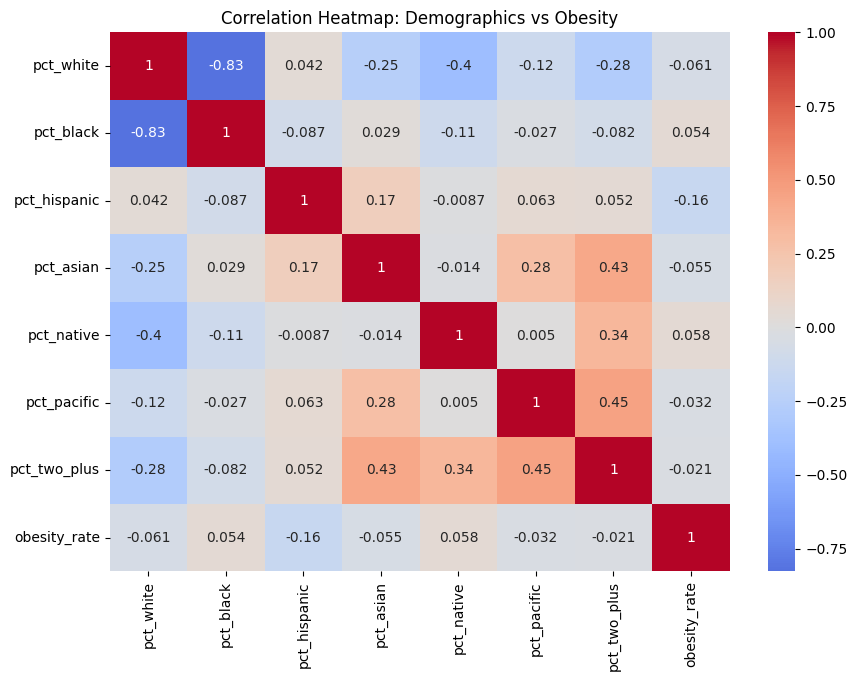

In [34]:
demo_cols = [
    "pct_white", "pct_black", "pct_hispanic",
    "pct_asian", "pct_native", "pct_pacific", "pct_two_plus"
]

corr = df_final[demo_cols + ["obesity_rate"]].corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap: Demographics vs Obesity")
plt.show()


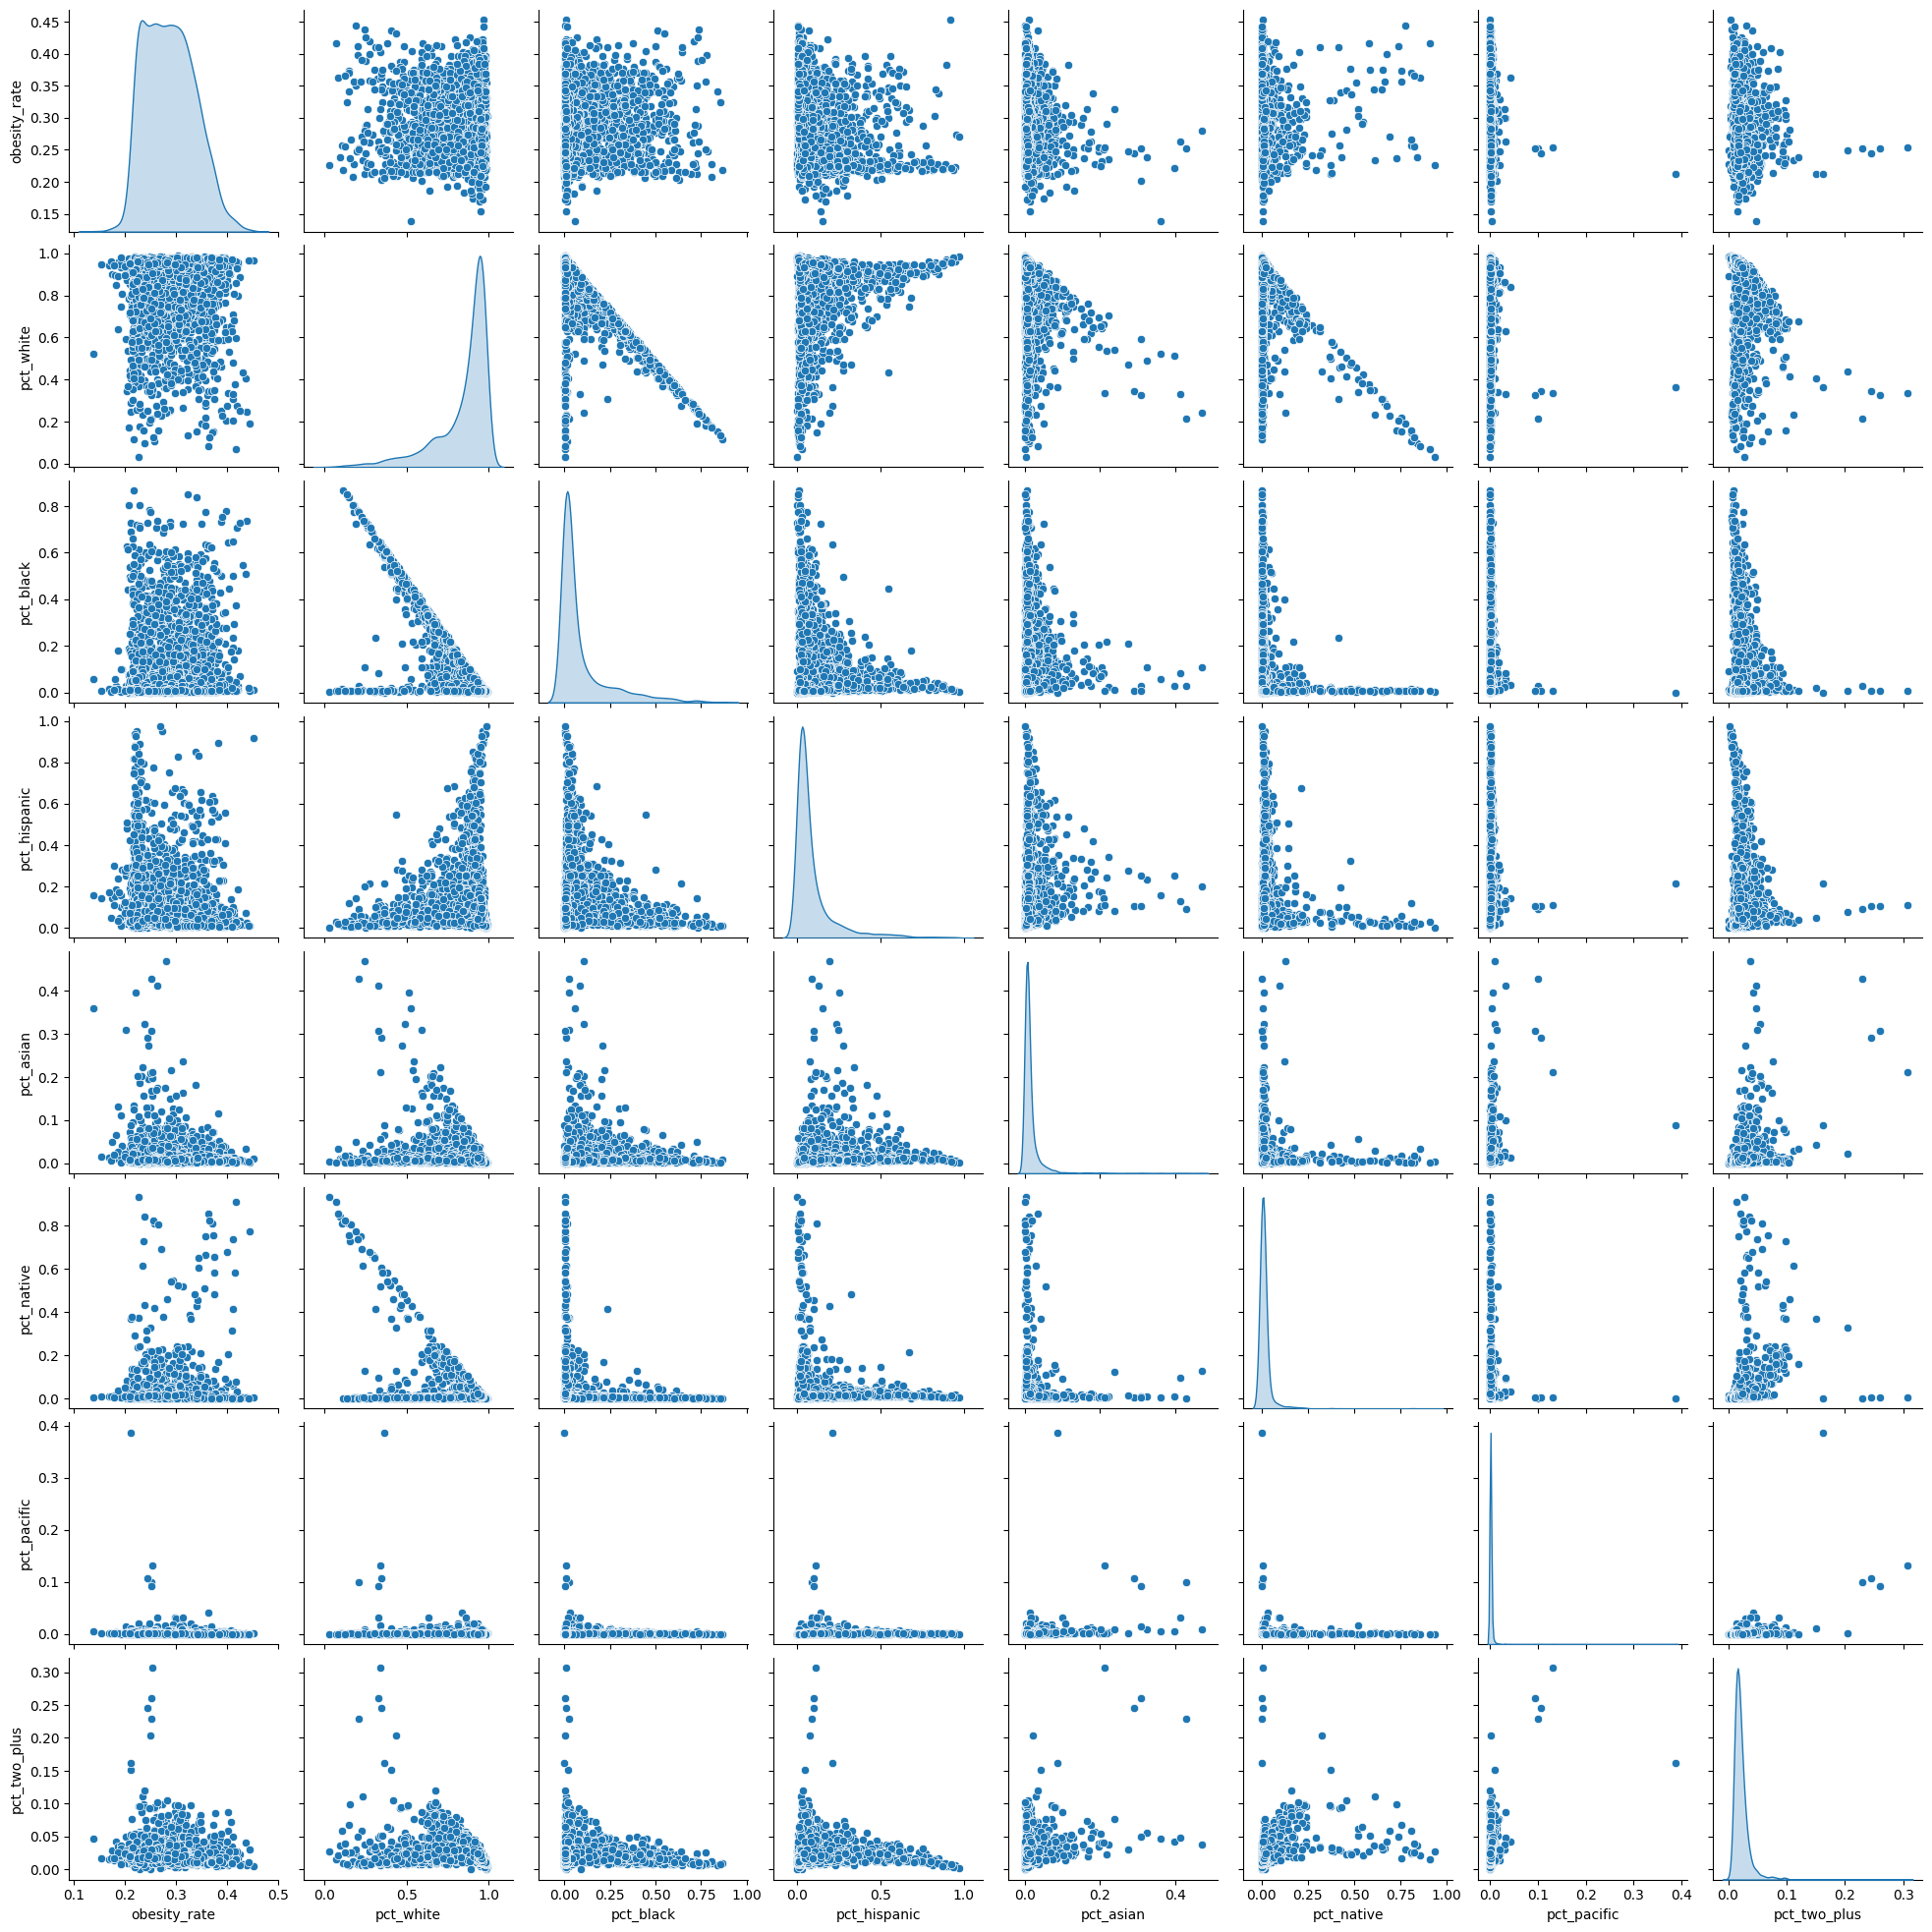

In [35]:
sns.pairplot(df_final[["obesity_rate"] + demo_cols], diag_kind="kde")
plt.show()

features = physical inactivity, unemployment, median_income, poverty_rate, pct_hispanic, pct_native, pct_black

# Exploring More in Physical inactivity

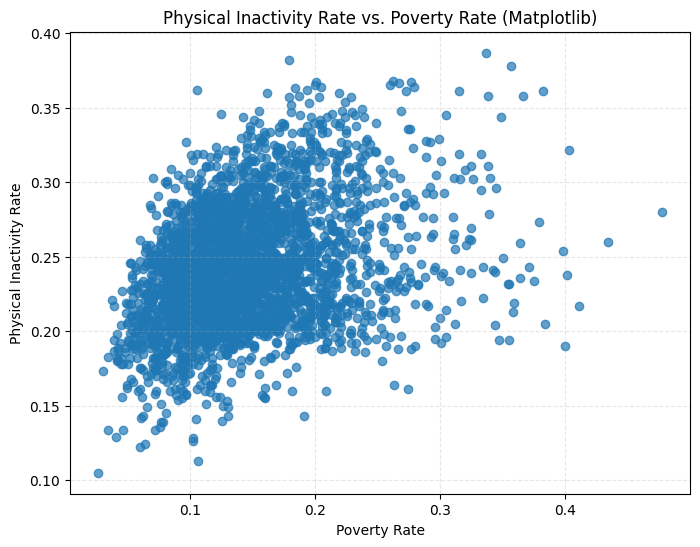

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(x=df_final["poverty_rate"], y=df_final["physical_inactivity_rate"], alpha=0.7)
plt.title("Physical Inactivity Rate vs. Poverty Rate (Matplotlib)")
plt.xlabel("Poverty Rate")
plt.ylabel("Physical Inactivity Rate")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

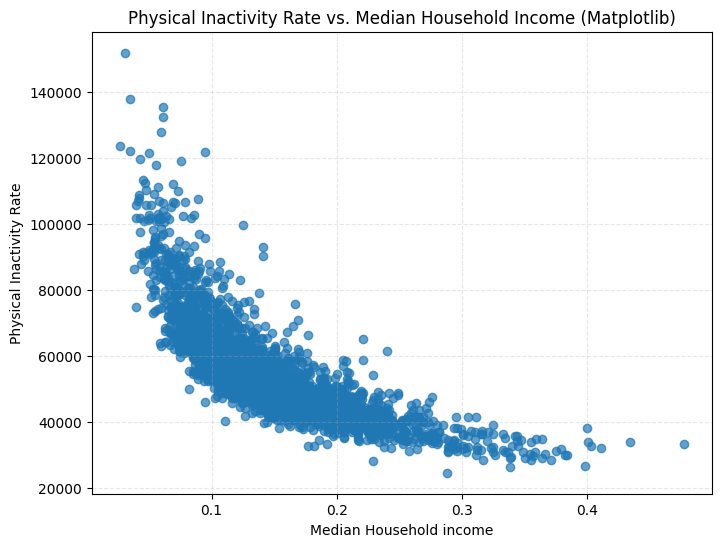

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(x=df_final["poverty_rate"], y=df_final["median_household_income"], alpha=0.7)
plt.title("Physical Inactivity Rate vs. Median Household Income (Matplotlib)")
plt.xlabel("Median Household income")
plt.ylabel("Physical Inactivity Rate")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()